In [29]:
import os, shutil
import io
from io import StringIO
import re
import sys
from contextlib import redirect_stdout
from keras import models
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import scipy.optimize as opt
import scipy.stats as sp
from scipy.stats import kde
import importlib as im
from sklearn import metrics
import csv

import cnn_utilities as cn
import uq_utilities as uq

In [30]:
# load trained model and normalization values
my_model = models.load_model("../saved_models/train_extant_R0_sampleRate_migrationRate.hdf5")

mean_sd = pd.read_csv("../saved_models/train_extant_normalization_label_mean_sd.csv", 
                     index_col = 0).to_numpy()

train_means = mean_sd[0,:]
train_sd = mean_sd[1,:]
train_aux_priors_means = train_means[3:,]
train_aux_priors_sd = train_sd[3:,]

num_locs = 5
max_tips = 502


In [31]:
# training and validation data
extant_data = pd.read_csv("../data_files/extant_training_set_0to40.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()

extant_labels = pd.read_csv("../data_files/extant_training_set_0to40_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()



In [32]:
###############################################
# compute and gather auxilliary prior data ##
##############################################
extant_subsample_prop = extant_data[:,(max_tips-1) * 7]
phylocomp_mu = extant_data[:,(max_tips - 3) * 7]
extant_num_tips = cn.get_num_tips(extant_data)

aux_phylocomp = np.vstack((phylocomp_mu, extant_subsample_prop, extant_num_tips,
                          extant_labels[:,8], extant_labels[:,9])).transpose()

norm_aux_phylocomp = cn.normalize(aux_phylocomp, (train_aux_priors_means, train_aux_priors_sd))


# create input tensors
extant_treeLocation_tensor, extant_prior_tensor = cn.create_data_tensors(data = extant_data, 
                                                                                    mu = norm_aux_phylocomp[:,0],
                                                                                    subsample_prop = norm_aux_phylocomp[:,1],
                                                                                    num_tips = norm_aux_phylocomp[:,2],
                                                                                    tmrca = norm_aux_phylocomp[:,3],
                                                                                    mean_bl = norm_aux_phylocomp[:,4],
                                                                                    num_locs = num_locs,
                                                                                    max_tips = max_tips,
                                                                                    cblv_contains_mu_rho = True)

# PREDICT R0, sample rate, migration rate
extant_normalized_preds = my_model.predict([extant_treeLocation_tensor, extant_prior_tensor])

# reversing normalization
cnn_extant_preds = cn.denormalize(extant_normalized_preds, train_means[0:3], train_sd[0:3])
log_preds = cnn_extant_preds
cnn_extant_preds = np.exp(cnn_extant_preds)


In [ ]:

############ checking coverage #################


In [33]:
### coverage of CI for test dataset
cnn_phylocomp_preds = pd.read_table("../output/extant_cnn_preds.tsv", header = 0).to_numpy()
cnn_phylocomp_labels = pd.read_table("../output/extant_labels.tsv", header = 0).to_numpy()

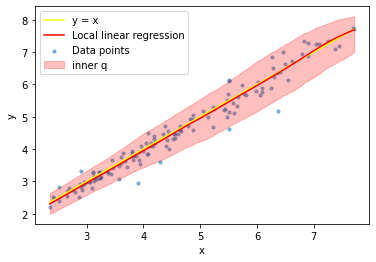

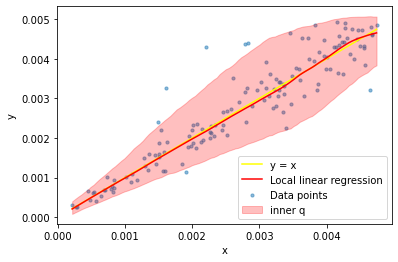

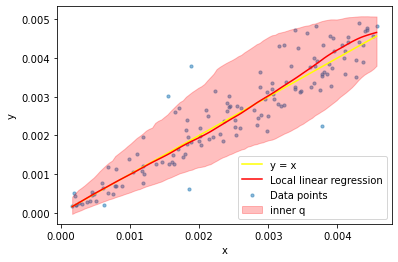

In [34]:
nn = 50000 #log_preds.shape[0]
for i in range(3):
    for qq in [.95]:
        f_mean, f_lower_q, f_upper_q = uq.fit_lowess_with_local_quantiles(np.exp(log_preds[0:nn,i]), 
                                                                          extant_labels[0:nn,5+i], 
                                                                          frac=0.1, inner_quantile=qq)
        x = cnn_phylocomp_preds[:,i]
        y = cnn_phylocomp_labels[:,i]
        i_mean = f_mean(x)
        i_lower_q = f_lower_q(x)
        i_upper_q = f_upper_q(x)
        uq.plot_lowess_fit_quantile(x, y, f_mean, f_lower_q, f_upper_q)

In [53]:
# make dictionaries containing interval estimating functions
# the keys should be the quantile number
# the values should be (lower_q_fun, upper_q_fun)

nn = log_preds.shape[0]

R0_cpi_fun = {}
delta_cpi_fun = {}
m_cpi_fun = {}

inner_q = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
for q in inner_q:
    m, lower_q, upper_q = uq.fit_lowess_with_local_quantiles(np.exp(log_preds[0:nn,0]),
                                                   extant_labels[0:nn,5], 
                                                   frac=0.1, inner_quantile=q)
    R0_cpi_fun[q] = (lower_q, upper_q)
    
    m, lower_q, upper_q = uq.fit_lowess_with_local_quantiles(np.exp(log_preds[0:nn,1]),
                                               extant_labels[0:nn,6], 
                                               frac=0.1, inner_quantile=q)
    delta_cpi_fun[q] = (lower_q, upper_q)
    
    m, lower_q, upper_q = uq.fit_lowess_with_local_quantiles(np.exp(log_preds[0:nn,2]),
                                               extant_labels[0:nn,7], 
                                               frac=0.1, inner_quantile=q)
    m_cpi_fun[q] = (lower_q, upper_q)
    
    print(str(q) + " is done")


0.05 is done
0.1 is done
0.25 is done
0.5 is done
0.75 is done
0.9 is done
0.95 is done


In [27]:
nn = 8000 #log_preds.shape[0]
i=0
R0_coverage = uq.make_coverage_set(np.exp(log_preds[0:nn,i]), extant_labels[0:nn,5+i], 
                                   cnn_phylocomp_preds[:,i], cnn_phylocomp_labels[:,i])
i=1
delta_coverage = uq.make_coverage_set(np.exp(log_preds[0:nn,i]), extant_labels[0:nn,5+i],  
                                   cnn_phylocomp_preds[:,i], cnn_phylocomp_labels[:,i])
i=2
m_coverage = uq.make_coverage_set(np.exp(log_preds[0:nn,i]), extant_labels[0:nn,5+i],  
                                   cnn_phylocomp_preds[:,i], cnn_phylocomp_labels[:,i])

0.05 finished: 8.695652173913043
0.1 finished: 13.043478260869565
0.25 finished: 26.08695652173913
0.5 finished: 52.89855072463768
0.75 finished: 79.71014492753623
0.9 finished: 90.57971014492753
0.95 finished: 93.47826086956522
0.05 finished: 7.246376811594203
0.1 finished: 11.594202898550725
0.25 finished: 23.18840579710145
0.5 finished: 54.347826086956516
0.75 finished: 77.53623188405797
0.9 finished: 89.13043478260869
0.95 finished: 94.20289855072464
0.05 finished: 5.072463768115942
0.1 finished: 9.420289855072465
0.25 finished: 23.91304347826087
0.5 finished: 47.82608695652174
0.75 finished: 75.36231884057972
0.9 finished: 89.13043478260869
0.95 finished: 94.92753623188406


In [947]:
# write to file
df_cnn_coverage = pd.DataFrame(np.transpose(np.vstack((R0_coverage, delta_coverage, m_coverage))), 
                                            columns = ["R0", "sample_rate", "migration_rate"], 
                               index = ["5", "10", "25", "50", "75", "90", "95"])
df_cnn_coverage.to_csv('../data_files/cnn_coverage.tsv', sep = "\t", index = True)

In [40]:
import uq_utilities as uq
im.reload(uq)

<module 'uq_utilities' from 'C:\\Users\\ammon_work\\Desktop\\RESEARCH_PROJECTS\\phylogeo_epi_cnn\\neural_network_dev\\uq_and_adequacy\\uq_utilities.py'>

ERROR! Session/line number was not unique in database. History logging moved to new session 3444


In [54]:
# measure coverage of predictions on out-of-model test data (misspecified)


In [56]:
# make coverage sets for R0 misspecification experiments
cnn_miss_r0_preds = pd.read_table("../output/misspec_R0_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_r0_labels = pd.read_table("../output/misspec_R0_labels.tsv", header = 0).to_numpy()

i=0
missR0_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_r0_preds[:,i], cnn_miss_r0_labels[:,i], q_fun = R0_cpi_fun)
i=1
missR0_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_r0_preds[:,i], cnn_miss_r0_labels[:,i], q_fun = delta_cpi_fun)
i=2
missR0_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_r0_preds[:,i], cnn_miss_r0_labels[:,i], q_fun = m_cpi_fun)

0.05 finished: 0.0
0.1 finished: 0.0
0.25 finished: 2.1505376344086025
0.5 finished: 5.376344086021505
0.75 finished: 13.978494623655912
0.9 finished: 31.182795698924732
0.95 finished: 41.935483870967744
0.05 finished: 3.225806451612903
0.1 finished: 6.451612903225806
0.25 finished: 20.43010752688172
0.5 finished: 40.86021505376344
0.75 finished: 63.44086021505376
0.9 finished: 81.72043010752688
0.95 finished: 91.39784946236558
0.05 finished: 1.0752688172043012
0.1 finished: 3.225806451612903
0.25 finished: 11.827956989247312
0.5 finished: 21.50537634408602
0.75 finished: 44.086021505376344
0.9 finished: 63.44086021505376
0.95 finished: 79.56989247311827


In [57]:
# make coverage sets for delta misspecification experiments

cnn_miss_delta_preds = pd.read_table("../output/misspec_delta_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_delta_labels = pd.read_table("../output/misspec_delta_labels.tsv", header = 0).to_numpy()

i=0
missDelta_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_delta_preds[:,i], cnn_miss_delta_labels[:,i], q_fun = R0_cpi_fun)
i=1
missDelta_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_delta_preds[:,i], cnn_miss_delta_labels[:,i], q_fun = delta_cpi_fun)
i=2
missDelta_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_delta_preds[:,i], cnn_miss_delta_labels[:,i], q_fun = m_cpi_fun)

0.05 finished: 7.627118644067797
0.1 finished: 11.864406779661017
0.25 finished: 24.576271186440678
0.5 finished: 44.91525423728814
0.75 finished: 56.779661016949156
0.9 finished: 79.66101694915254
0.95 finished: 88.98305084745762
0.05 finished: 0.0
0.1 finished: 0.0
0.25 finished: 5.084745762711865
0.5 finished: 22.88135593220339
0.75 finished: 35.59322033898305
0.9 finished: 57.6271186440678
0.95 finished: 67.79661016949152
0.05 finished: 1.694915254237288
0.1 finished: 3.389830508474576
0.25 finished: 12.711864406779661
0.5 finished: 34.74576271186441
0.75 finished: 53.38983050847458
0.9 finished: 70.33898305084746
0.95 finished: 83.05084745762711


In [58]:
# make coverage sets for R0 misspecification experiments
cnn_miss_m_preds = pd.read_table("../output/misspec_migration_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_m_labels = pd.read_table("../output/misspec_migration_labels.tsv", header = 0).to_numpy()

i=0
missM_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_m_preds[:,i], cnn_miss_m_labels[:,i], q_fun = R0_cpi_fun)
i=1
missM_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_m_preds[:,i], cnn_miss_m_labels[:,i], q_fun = delta_cpi_fun)
i=2
missM_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_m_preds[:,i], cnn_miss_m_labels[:,i], q_fun = m_cpi_fun)

0.05 finished: 7.777777777777778
0.1 finished: 14.444444444444443
0.25 finished: 33.33333333333333
0.5 finished: 51.11111111111111
0.75 finished: 75.55555555555556
0.9 finished: 85.55555555555556
0.95 finished: 92.22222222222223
0.05 finished: 4.444444444444445
0.1 finished: 10.0
0.25 finished: 26.666666666666668
0.5 finished: 47.77777777777778
0.75 finished: 71.11111111111111
0.9 finished: 86.66666666666667
0.95 finished: 96.66666666666667
0.05 finished: 3.3333333333333335
0.1 finished: 4.444444444444445
0.25 finished: 16.666666666666664
0.5 finished: 28.888888888888886
0.75 finished: 51.11111111111111
0.9 finished: 67.77777777777779
0.95 finished: 77.77777777777779


In [72]:
# make coverage sets for R0 misspecification experiments

cnn_miss_loc_preds = pd.read_table("../output/misspec_numloc_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_loc_labels = pd.read_table("../output/misspec_numloc_labels.tsv", header = 0).to_numpy()

i=0
missNumLoc_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_loc_preds[:,i], cnn_miss_loc_labels[:,i], q_fun = R0_cpi_fun)
i=1
missNumLoc_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_loc_preds[:,i], cnn_miss_loc_labels[:,i], q_fun = delta_cpi_fun)
i=2
missNumLoc_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_loc_preds[:,i], cnn_miss_loc_labels[:,i], q_fun = m_cpi_fun)

0.05 finished: 5.88235294117647
0.1 finished: 9.243697478991598
0.25 finished: 18.487394957983195
0.5 finished: 48.739495798319325
0.75 finished: 68.0672268907563
0.9 finished: 84.03361344537815
0.95 finished: 89.91596638655463
0.05 finished: 3.361344537815126
0.1 finished: 7.563025210084033
0.25 finished: 18.487394957983195
0.5 finished: 43.69747899159664
0.75 finished: 68.0672268907563
0.9 finished: 87.39495798319328
0.95 finished: 93.27731092436974
0.05 finished: 1.680672268907563
0.1 finished: 6.722689075630252
0.25 finished: 15.126050420168067
0.5 finished: 31.932773109243694
0.75 finished: 62.18487394957983
0.9 finished: 77.31092436974791
0.95 finished: 87.39495798319328


In [74]:
# make coverage sets for R0 misspecification experiments

cnn_miss_tree_preds = pd.read_table("../output/misspec_tree_cnn_preds.tsv", header = 0).to_numpy()
cnn_miss_tree_labels = pd.read_table("../output/misspec_tree_labels.tsv", header = 0).to_numpy()

i=0
missTree_R0_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_tree_preds[:,i], cnn_miss_tree_labels[:,i], q_fun = R0_cpi_fun)
i=1
missTree_delta_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_tree_preds[:,i], cnn_miss_tree_labels[:,i], q_fun = delta_cpi_fun)
i=2
missTree_m_coverage = uq.make_coverage_set(None, None, 
                                   cnn_miss_tree_preds[:,i], cnn_miss_tree_labels[:,i], q_fun = m_cpi_fun)

0.05 finished: 1.9801980198019802
0.1 finished: 5.9405940594059405
0.25 finished: 18.81188118811881
0.5 finished: 32.67326732673268
0.75 finished: 51.48514851485149
0.9 finished: 76.23762376237624
0.95 finished: 81.1881188118812
0.05 finished: 3.9603960396039604
0.1 finished: 4.9504950495049505
0.25 finished: 16.831683168316832
0.5 finished: 34.65346534653465
0.75 finished: 54.45544554455446
0.9 finished: 73.26732673267327
0.95 finished: 87.12871287128714
0.05 finished: 2.9702970297029703
0.1 finished: 6.9306930693069315
0.25 finished: 17.82178217821782
0.5 finished: 40.5940594059406
0.75 finished: 72.27722772277228
0.9 finished: 87.12871287128714
0.95 finished: 93.06930693069307
